# Decision Trees in Practice

In this assignment we will explore various techniques for preventing overfitting in decision trees. We will extend the implementation of the binary decision trees that we implemented in the previous assignment. You will have to use your solutions from this previous assignment and extend them.

In this assignment you will:

* Implement binary decision trees with different early stopping methods.
* Compare models with different stopping parameters.
* Visualize the concept of overfitting in decision trees.

Let's get started!

# Fire up GraphLab Create

Make sure you have the latest version of GraphLab Create.

In [1]:
import graphlab

# Load LendingClub Dataset

This assignment will use the [LendingClub](https://www.lendingclub.com/) dataset used in the previous two assignments.

In [2]:
loans = graphlab.SFrame('lending-club-data.gl/')

This non-commercial license of GraphLab Create for academic use is assigned to 201301146@daiict.ac.in and will expire on September 18, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1479308906.log


As before, we reassign the labels to have +1 for a safe loan, and -1 for a risky (bad) loan.

In [3]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.remove_column('bad_loans')

We will be using the same 4 categorical features as in the previous assignment: 
1. grade of the loan 
2. the length of the loan term
3. the home ownership status: own, mortgage, rent
4. number of years of employment.

In the dataset, each of these features is a categorical feature. Since we are building a binary decision tree, we will have to convert this to binary data in a subsequent section using 1-hot encoding.

In [4]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home_ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
target = 'safe_loans'
loans = loans[features + [target]]

## Subsample dataset to make sure classes are balanced

Just as we did in the previous assignment, we will undersample the larger class (safe loans) in order to balance out our dataset. This means we are throwing away many data points. We used `seed = 1` so everyone gets the same results.

In [5]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]

# Since there are less risky loans than safe loans, find the ratio of the sizes
# and use that percentage to undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
safe_loans = safe_loans_raw.sample(percentage, seed = 1)
risky_loans = risky_loans_raw
loans_data = risky_loans.append(safe_loans)

print "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data))
print "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))
print "Total number of loans in our new dataset :", len(loans_data)

Percentage of safe loans                 : 0.502236174422
Percentage of risky loans                : 0.497763825578
Total number of loans in our new dataset : 46508


**Note:** There are many approaches for dealing with imbalanced data, including some where we modify the learning algorithm. These approaches are beyond the scope of this course, but some of them are reviewed in this [paper](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5128907&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F69%2F5173046%2F05128907.pdf%3Farnumber%3D5128907 ). For this assignment, we use the simplest possible approach, where we subsample the overly represented class to get a more balanced dataset. In general, and especially when the data is highly imbalanced, we recommend using more advanced methods.

## Transform categorical data into binary features

Since we are implementing **binary decision trees**, we transform our categorical data into binary data using 1-hot encoding, just as in the previous assignment. Here is the summary of that discussion:

For instance, the **home_ownership** feature represents the home ownership status of the loanee, which is either `own`, `mortgage` or `rent`. For example, if a data point has the feature 
```
   {'home_ownership': 'RENT'}
```
we want to turn this into three features: 
```
 { 
   'home_ownership = OWN'      : 0, 
   'home_ownership = MORTGAGE' : 0, 
   'home_ownership = RENT'     : 1
 }
```

Since this code requires a few Python and GraphLab tricks, feel free to use this block of code as is. Refer to the API documentation for a deeper understanding.


In [6]:
loans_data = risky_loans.append(safe_loans)
for feature in features:
    loans_data_one_hot_encoded = loans_data[feature].apply(lambda x: {x: 1})    
    loans_data_unpacked = loans_data_one_hot_encoded.unpack(column_name_prefix=feature)
    
    # Change None's to 0's
    for column in loans_data_unpacked.column_names():
        loans_data_unpacked[column] = loans_data_unpacked[column].fillna(0)

    loans_data.remove_column(feature)
    loans_data.add_columns(loans_data_unpacked)

The feature columns now look like this:

In [7]:
features = loans_data.column_names()
features.remove('safe_loans')  # Remove the response variable
features

['grade.A',
 'grade.B',
 'grade.C',
 'grade.D',
 'grade.E',
 'grade.F',
 'grade.G',
 'term. 36 months',
 'term. 60 months',
 'home_ownership.MORTGAGE',
 'home_ownership.OTHER',
 'home_ownership.OWN',
 'home_ownership.RENT',
 'emp_length.1 year',
 'emp_length.10+ years',
 'emp_length.2 years',
 'emp_length.3 years',
 'emp_length.4 years',
 'emp_length.5 years',
 'emp_length.6 years',
 'emp_length.7 years',
 'emp_length.8 years',
 'emp_length.9 years',
 'emp_length.< 1 year',
 'emp_length.n/a']

## Train-Validation split

We split the data into a train-validation split with 80% of the data in the training set and 20% of the data in the validation set. We use `seed=1` so that everyone gets the same result.

In [8]:
train_data, test_data = loans_data.random_split(.8, seed=1)

# Early stopping methods for decision trees

In this section, we will extend the **binary tree implementation** from the previous assignment in order to handle some early stopping conditions. Recall the 3 early stopping methods that were discussed in lecture:

1. Reached a **maximum depth**. (set by parameter `max_depth`).
2. Reached a **minimum node size**. (set by parameter `min_node_size`).
3. Don't split if the **gain in error reduction** is too small. (set by parameter `min_error_reduction`).

For the rest of this assignment, we will refer to these three as **early stopping conditions 1, 2, and 3**.

## Early stopping condition 1: Maximum depth

Recall that we already implemented the maximum depth stopping condition in the previous assignment. In this assignment, we will experiment with this condition a bit more and also write code to implement the 2nd and 3rd early stopping conditions.

We will be reusing code from the previous assignment and then building upon this.  We will **alert you** when you reach a function that was part of the previous assignment so that you can simply copy and past your previous code.

## Early stopping condition 2: Minimum node size

The function **reached_minimum_node_size** takes 2 arguments:

1. The `data` (from a node)
2. The minimum number of data points that a node is allowed to split on, `min_node_size`.

This function simply calculates whether the number of data points at a given node is less than or equal to the specified minimum node size. This function will be used to detect this early stopping condition in the **decision_tree_create** function.

Fill in the parts of the function below where you find `## YOUR CODE HERE`.  There is **one** instance in the function below.

In [9]:
def reached_minimum_node_size(data, min_node_size):
    # Return True if the number of data points is less than or equal to the minimum node size.
    ## YOUR CODE HERE
    if len(data) <= min_node_size :
        return True
    return False

** Quiz Question:** Given an intermediate node with 6 safe loans and 3 risky loans, if the `min_node_size` parameter is 10, what should the tree learning algorithm do next?

## Early stopping condition 3: Minimum gain in error reduction

The function **error_reduction** takes 2 arguments:

1. The error **before** a split, `error_before_split`.
2. The error **after** a split, `error_after_split`.

This function computes the gain in error reduction, i.e., the difference between the error before the split and that after the split. This function will be used to detect this early stopping condition in the **decision_tree_create** function.

Fill in the parts of the function below where you find `## YOUR CODE HERE`.  There is **one** instance in the function below. 

In [10]:
def error_reduction(error_before_split, error_after_split):
    # Return the error before the split minus the error after the split.
    ## YOUR CODE HERE
    return (error_before_split - error_after_split)

** Quiz Question:** Assume an intermediate node has 6 safe loans and 3 risky loans.  For each of 4 possible features to split on, the error reduction is 0.0, 0.05, 0.1, and 0.14, respectively. If the **minimum gain in error reduction** parameter is set to 0.2, what should the tree learning algorithm do next?

## Grabbing binary decision tree helper functions from past assignment

Recall from the previous assignment that we wrote a function `intermediate_node_num_mistakes` that calculates the number of **misclassified examples** when predicting the **majority class**. This is used to help determine which feature is best to split on at a given node of the tree.

**Please copy and paste your code for `intermediate_node_num_mistakes` here**.

In [11]:
def intermediate_node_num_mistakes(labels_in_node):
    # Corner case: If labels_in_node is empty, return 0
    if len(labels_in_node) == 0:
        return 0
    
    # Count the number of 1's (safe loans)
    pos = len(labels_in_node[labels_in_node == 1])
    
    # Count the number of -1's (risky loans)
    neg = len(labels_in_node[labels_in_node == -1])
                
    # Return the number of mistakes that the majority classifier makes.
    if pos > neg :
        return neg
    return pos

We then wrote a function `best_splitting_feature` that finds the best feature to split on given the data and a list of features to consider.

**Please copy and paste your `best_splitting_feature` code here**.

In [12]:
def best_splitting_feature(data, features, target):
    
    best_feature = None # Keep track of the best feature 
    best_error = 10     # Keep track of the best error so far 
    # Note: Since error is always <= 1, we should intialize it with something larger than 1.

    # Convert to float to make sure error gets computed correctly.
    num_data_points = float(len(data))  
    
    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        left_split = data[data[feature] == 0]
        
        # The right split will have all data points where the feature value is 1
        ## YOUR CODE HERE
        right_split = data[data[feature] == 1] 
            
        # Calculate the number of misclassified examples in the left split.
        # Remember that we implemented a function for this! (It was called intermediate_node_num_mistakes)
        # YOUR CODE HERE
        left_mistakes = intermediate_node_num_mistakes(left_split['safe_loans'])            

        # Calculate the number of misclassified examples in the right split.
        ## YOUR CODE HERE
        right_mistakes = intermediate_node_num_mistakes(right_split['safe_loans'])
            
        # Compute the classification error of this split.
        # Error = (# of mistakes (left) + # of mistakes (right)) / (# of data points)
        ## YOUR CODE HERE
        error = ((left_mistakes + right_mistakes)/num_data_points)

        # If this is the best error we have found so far, store the feature as best_feature and the error as best_error
        ## YOUR CODE HERE
        if error < best_error:
            best_error = error
            best_feature = feature
        
    
    return best_feature # Return the best feature we found

Finally, recall the function `create_leaf` from the previous assignment, which creates a leaf node given a set of target values.  

**Please copy and paste your `create_leaf` code here**.

In [13]:
def create_leaf(target_values):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'left' : None,
            'right' : None,
            'is_leaf':True     }   ## YOUR CODE HERE
    
    # Count the number of data points that are +1 and -1 in this node.
    num_ones = len(target_values[target_values == +1])
    num_minus_ones = len(target_values[target_values == -1])
    
    # For the leaf node, set the prediction to be the majority class.
    # Store the predicted class (1 or -1) in leaf['prediction']
    if num_ones > num_minus_ones:
        leaf['prediction'] = 1         ## YOUR CODE HERE
    else:
        leaf['prediction'] = -1        ## YOUR CODE HERE
        
    # Return the leaf node        
    return leaf

## Incorporating new early stopping conditions in binary decision tree implementation

Now, you will implement a function that builds a decision tree handling the three early stopping conditions described in this assignment.  In particular, you will write code to detect early stopping conditions 2 and 3.  You implemented above the functions needed to detect these conditions.  The 1st early stopping condition, **max_depth**, was implemented in the previous assigment and you will not need to reimplement this.  In addition to these early stopping conditions, the typical stopping conditions of having no mistakes or no more features to split on (which we denote by "stopping conditions" 1 and 2) are also included as in the previous assignment.

**Implementing early stopping condition 2: minimum node size:**

* **Step 1:** Use the function **reached_minimum_node_size** that you implemented earlier to write an if condition to detect whether we have hit the base case, i.e., the node does not have enough data points and should be turned into a leaf. Don't forget to use the `min_node_size` argument.
* **Step 2:** Return a leaf. This line of code should be the same as the other (pre-implemented) stopping conditions.


**Implementing early stopping condition 3: minimum error reduction:**

**Note:** This has to come after finding the best splitting feature so we can calculate the error after splitting in order to calculate the error reduction.

* **Step 1:** Calculate the **classification error before splitting**.  Recall that classification error is defined as:

$$
\text{classification error} = \frac{\text{# mistakes}}{\text{# total examples}}
$$
* **Step 2:** Calculate the **classification error after splitting**. This requires calculating the number of mistakes in the left and right splits, and then dividing by the total number of examples.
* **Step 3:** Use the function **error_reduction** to that you implemented earlier to write an if condition to detect whether  the reduction in error is less than the constant provided (`min_error_reduction`). Don't forget to use that argument.
* **Step 4:** Return a leaf. This line of code should be the same as the other (pre-implemented) stopping conditions.

Fill in the places where you find `## YOUR CODE HERE`. There are **seven** places in this function for you to fill in.

In [14]:
def decision_tree_create(data, features, target, current_depth = 0, 
                         max_depth = 10, min_node_size=1, 
                         min_error_reduction=0.0):
    
    remaining_features = features[:] # Make a copy of the features.
    
    target_values = data[target]
    print "--------------------------------------------------------------------"
    print "Subtree, depth = %s (%s data points)." % (current_depth, len(target_values))
    
    
    # Stopping condition 1: All nodes are of the same type.
    if intermediate_node_num_mistakes(target_values) == 0:
        print "Stopping condition 1 reached. All data points have the same target value."                
        return create_leaf(target_values)
    
    # Stopping condition 2: No more features to split on.
    if remaining_features == []:
        print "Stopping condition 2 reached. No remaining features."                
        return create_leaf(target_values)    
    
    # Early stopping condition 1: Reached max depth limit.
    if current_depth >= max_depth:
        print "Early stopping condition 1 reached. Reached maximum depth."
        return create_leaf(target_values)
    
    # Early stopping condition 2: Reached the minimum node size.
    # If the number of data points is less than or equal to the minimum size, return a leaf.
    if reached_minimum_node_size(data,min_node_size) :          ## YOUR CODE HERE 
        print "Early stopping condition 2 reached. Reached minimum node size."
        return create_leaf(target_values)
    
    # Find the best splitting feature
    splitting_feature = best_splitting_feature(data, features, target)
    
    # Split on the best feature that we found. 
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    # Early stopping condition 3: Minimum error reduction
    # Calculate the error before splitting (number of misclassified examples 
    # divided by the total number of examples)
    error_before_split = intermediate_node_num_mistakes(target_values) / float(len(data))
    
    # Calculate the error after splitting (number of misclassified examples 
    # in both groups divided by the total number of examples)
    left_mistakes = intermediate_node_num_mistakes(left_split[target])
    right_mistakes = intermediate_node_num_mistakes(right_split[target])
    error_after_split = (left_mistakes + right_mistakes) / float(len(data))
    
    # If the error reduction is LESS THAN OR EQUAL TO min_error_reduction, return a leaf.
    if error_reduction(error_before_split,error_after_split) <= min_error_reduction :
        print "Early stopping condition 3 reached. Minimum error reduction."
        return create_leaf(target_values)
    
    
    remaining_features.remove(splitting_feature)
    print "Split on feature %s. (%s, %s)" % (\
                      splitting_feature, len(left_split), len(right_split))
    
    
    # Repeat (recurse) on left and right subtrees
    left_tree = decision_tree_create(left_split, remaining_features, target, 
                                     current_depth + 1, max_depth, min_node_size, min_error_reduction)        
    
    ## YOUR CODE HERE
    right_tree = decision_tree_create(right_split, remaining_features, target, 
                                     current_depth + 1, max_depth, min_node_size, min_error_reduction)
    
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

Here is a function to count the nodes in your tree:

In [15]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

Run the following test code to check your implementation. Make sure you get **'Test passed'** before proceeding.

In [16]:
small_decision_tree = decision_tree_create(train_data, features, 'safe_loans', max_depth = 2, 
                                        min_node_size = 10, min_error_reduction=0.0)
if count_nodes(small_decision_tree) == 7:
    print 'Test passed!'
else:
    print 'Test failed... try again!'
    print 'Number of nodes found                :', count_nodes(small_decision_tree)
    print 'Number of nodes that should be there : 7'

--------------------------------------------------------------------
Subtree, depth = 0 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 1 (9223 data points).
Split on feature grade.A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 2 (9122 data points).
Early stopping condition 1 reached. Reached maximum depth.
--------------------------------------------------------------------
Subtree, depth = 2 (101 data points).
Early stopping condition 1 reached. Reached maximum depth.
--------------------------------------------------------------------
Subtree, depth = 1 (28001 data points).
Split on feature grade.D. (23300, 4701)
--------------------------------------------------------------------
Subtree, depth = 2 (23300 data points).
Early stopping condition 1 reached. Reached maximum depth.
-----------------------------------------------

## Build a tree!

Now that your code is working, we will train a tree model on the **train_data** with
* `max_depth = 6`
* `min_node_size = 100`, 
* `min_error_reduction = 0.0`

**Warning**: This code block may take a minute to learn. 

In [17]:
my_decision_tree_new = decision_tree_create(train_data, features, 'safe_loans', max_depth = 6, 
                                min_node_size = 100, min_error_reduction=0.0)

--------------------------------------------------------------------
Subtree, depth = 0 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 1 (9223 data points).
Split on feature grade.A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 2 (9122 data points).
Early stopping condition 3 reached. Minimum error reduction.
--------------------------------------------------------------------
Subtree, depth = 2 (101 data points).
Split on feature emp_length.n/a. (96, 5)
--------------------------------------------------------------------
Subtree, depth = 3 (96 data points).
Early stopping condition 2 reached. Reached minimum node size.
--------------------------------------------------------------------
Subtree, depth = 3 (5 data points).
Early stopping condition 2 reached. Reached minimum node size.
-------------------------------------------

Let's now train a tree model **ignoring early stopping conditions 2 and 3** so that we get the same tree as in the previous assignment.  To ignore these conditions, we set `min_node_size=0` and `min_error_reduction=-1` (a negative value).

In [18]:
my_decision_tree_old = decision_tree_create(train_data, features, 'safe_loans', max_depth = 6, 
                                min_node_size = 0, min_error_reduction=-1)

--------------------------------------------------------------------
Subtree, depth = 0 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 1 (9223 data points).
Split on feature grade.A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 2 (9122 data points).
Split on feature grade.B. (8074, 1048)
--------------------------------------------------------------------
Subtree, depth = 3 (8074 data points).
Split on feature grade.C. (5884, 2190)
--------------------------------------------------------------------
Subtree, depth = 4 (5884 data points).
Split on feature grade.D. (3826, 2058)
--------------------------------------------------------------------
Subtree, depth = 5 (3826 data points).
Split on feature grade.E. (1693, 2133)
--------------------------------------------------------------------
Subtree, depth = 6 (1693 data points).
E

## Making predictions

Recall that in the previous assignment you implemented a function `classify` to classify a new point `x` using a given `tree`.

**Please copy and paste your `classify` code here**.

In [19]:
def classify(tree, x, annotate = False):   
    # if the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print "At leaf, predicting %s" % tree['prediction']
        return tree['prediction'] 
    else:
        # split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print "Split on %s = %s" % (tree['splitting_feature'], split_feature_value)
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

Now, let's consider the first example of the validation set and see what the `my_decision_tree_new` model predicts for this data point.

In [20]:
validation_set[0]

{'emp_length.1 year': 0,
 'emp_length.10+ years': 0,
 'emp_length.2 years': 1,
 'emp_length.3 years': 0,
 'emp_length.4 years': 0,
 'emp_length.5 years': 0,
 'emp_length.6 years': 0,
 'emp_length.7 years': 0,
 'emp_length.8 years': 0,
 'emp_length.9 years': 0,
 'emp_length.< 1 year': 0,
 'emp_length.n/a': 0,
 'grade.A': 0,
 'grade.B': 0,
 'grade.C': 0,
 'grade.D': 1,
 'grade.E': 0,
 'grade.F': 0,
 'grade.G': 0,
 'home_ownership.MORTGAGE': 0,
 'home_ownership.OTHER': 0,
 'home_ownership.OWN': 0,
 'home_ownership.RENT': 1,
 'safe_loans': -1,
 'term. 36 months': 0,
 'term. 60 months': 1}

In [21]:
print 'Predicted class: %s ' % classify(my_decision_tree_new, validation_set[0])

Predicted class: -1 


Let's add some annotations to our prediction to see what the prediction path was that lead to this predicted class:

In [22]:
classify(my_decision_tree_new, validation_set[0], annotate = True)

Split on term. 36 months = 0
Split on grade.A = 0
At leaf, predicting -1


-1

Let's now recall the prediction path for the decision tree learned in the previous assignment, which we recreated here as `my_decision_tree_old`.

In [23]:
classify(my_decision_tree_old, validation_set[0], annotate = True)

Split on term. 36 months = 0
Split on grade.A = 0
Split on grade.B = 0
Split on grade.C = 0
Split on grade.D = 1
Split on grade.E = 0
At leaf, predicting -1


-1

** Quiz Question:** For `my_decision_tree_new` trained with `max_depth = 6`, `min_node_size = 100`, `min_error_reduction=0.0`, is the prediction path for `validation_set[0]` shorter, longer, or the same as for `my_decision_tree_old` that ignored the early stopping conditions 2 and 3?

**Quiz Question:** For `my_decision_tree_new` trained with `max_depth = 6`, `min_node_size = 100`, `min_error_reduction=0.0`, is the prediction path for **any point** always shorter, always longer, always the same, shorter or the same, or longer or the same as for `my_decision_tree_old` that ignored the early stopping conditions 2 and 3?

** Quiz Question:** For a tree trained on **any** dataset using `max_depth = 6`, `min_node_size = 100`, `min_error_reduction=0.0`, what is the maximum number of splits encountered while making a single prediction?

## Evaluating the model

Now let us evaluate the model that we have trained. You implemented this evaluation in the function `evaluate_classification_error` from the previous assignment.

**Please copy and paste your `evaluate_classification_error` code here**.

In [17]:
def evaluate_classification_error(tree, data, target):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply(lambda x: classify(tree, x))
    
    # Once you've made the predictions, calculate the classification error and return it
    ## YOUR CODE HERE
    tot = float(len(data))
    mistakes = (prediction != data[target])
    no_mistakes = len(mistakes[mistakes == 1])
    error = no_mistakes/tot
    return error

In [20]:
def evaluate_tree(tree, data, target):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply(lambda x: classify(tree, x))
    
    # Once you've made the predictions, calculate the classification error and return it
    ## YOUR CODE HERE
    tot = float(len(data))
    mistakes = (prediction != data[target])
    no_mistakes = len(mistakes[mistakes == 1])
    #accuracy = ((tot - no_mistakes)/tot)*100
    #tp = float(len(mistakes[(mistakes == 1) & (data[target] == 1)]))
    #fp = float(len(mistakes[(mistakes == 1) & (data[target] == -1)]))
    #fn = float(len(mistakes[(mistakes == -1) & (data[target] == 1)]))
    tp = float(((prediction == 1) & (data[target] == 1)).sum())
    tn = float(((prediction == -1) & (data[target] == -1)).sum())
    fp = float(((prediction == 1) & (data[target] == -1)).sum())
    fn = float(((prediction == -1) & (data[target] == 1)).sum())
    accuracy = ((tp + tn)/(tot))*100
    precision = (tp/(tp + fp))*100
    recall = (tp/(tp + fn))*100
    F1 = (2*precision*recall)/(precision + recall)
    
    print (tp+fp+tn+fn)
    print tot
    #print tn
    #print fn
    print "Accuracy is: " + str(accuracy) + " %"
    print "Precision is: " + str(precision) + " %"
    print "Recall is: " + str(recall) + " %"
    print "F1 Score is: : %f" %F1

Now, let's use this function to evaluate the classification error of `my_decision_tree_new` on the **validation_set**.

In [25]:
evaluate_classification_error(my_decision_tree_new, validation_set, target)

0.38367083153813014

Now, evaluate the validation error using `my_decision_tree_old`.

In [26]:
evaluate_classification_error(my_decision_tree_old, validation_set, target)

0.3837785437311504

**Quiz Question:** Is the validation error of the new decision tree (using early stopping conditions 2 and 3) lower than, higher than, or the same as that of the old decision tree from the previous assignment?

# Exploring the effect of max_depth

We will compare three models trained with different values of the stopping criterion. We intentionally picked models at the extreme ends (**too small**, **just right**, and **too large**).

Train three models with these parameters:

1. **model_1**: max_depth = 2 (too small)
2. **model_2**: max_depth = 6 (just right)
3. **model_3**: max_depth = 14 (may be too large)

For each of these three, we set `min_node_size = 0` and `min_error_reduction = -1`.

** Note:** Each tree can take up to a few minutes to train. In particular, `model_3` will probably take the longest to train.

In [32]:
#depths = [2,6,14]
min_error = [-5,0,5]
train_error = []
test_error = []

for i in min_error :
    
    model = decision_tree_create(train_data, features, 'safe_loans', max_depth = 6, 
                                min_node_size = 0, min_error_reduction=i)
    test_error.append(evaluate_classification_error(model,test_data,target))
#model_2 = decision_tree_create(train_data, features, 'safe_loans', max_depth = 6, 
#                                min_node_size = 0, min_error_reduction=-1)
#model_3 = decision_tree_create(train_data, features, 'safe_loans', max_depth = 14, 
#                                min_node_size = 0, min_error_reduction=-1)

--------------------------------------------------------------------
Subtree, depth = 0 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 1 (9223 data points).
Split on feature grade.A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 2 (9122 data points).
Split on feature grade.B. (8074, 1048)
--------------------------------------------------------------------
Subtree, depth = 3 (8074 data points).
Split on feature grade.C. (5884, 2190)
--------------------------------------------------------------------
Subtree, depth = 4 (5884 data points).
Split on feature grade.D. (3826, 2058)
--------------------------------------------------------------------
Subtree, depth = 5 (3826 data points).
Split on feature grade.E. (1693, 2133)
--------------------------------------------------------------------
Subtree, depth = 6 (1693 data points).
E

In [33]:
test_error

[0.3837785437311504, 0.3837785437311504, 0.503446790176648]

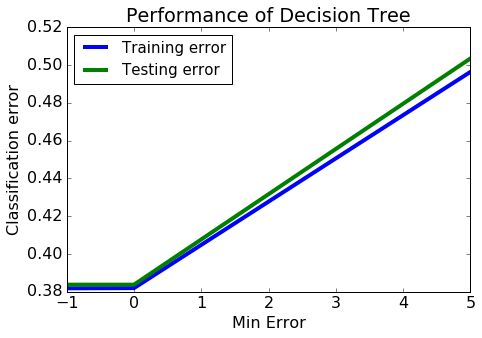

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 7, 5
plt.plot(min_error, train_error, '-', linewidth=4.0, label='Training error')
plt.plot(min_error, test_error, '-', linewidth=4.0, label='Testing error')
plt.title('Performance of Decision Tree')
plt.xlabel('Min Error')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})
plt.tight_layout()

In [ ]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(depths, test_error, '-', linewidth=4.0, label='Testing error')
plt.title('Performance of Decision Tree')
plt.xlabel('Max-depth')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

### Evaluating the models

Let us evaluate the models on the **train** and **validation** data. Let us start by evaluating the classification error on the training data:

In [41]:
print "Training data, classification error (model 1):", evaluate_classification_error(model_1, train_data,target)
print "Training data, classification error (model 2):", evaluate_classification_error(model_2, train_data,target)
print "Training data, classification error (model 3):", evaluate_classification_error(model_3, train_data,target)

 Training data, classification error (model 1): 0.400037610144
Training data, classification error (model 2): 0.381850419084
Training data, classification error (model 3): 0.374462712229


Now evaluate the classification error on the validation data.

In [42]:
print "Validation data, classification error (model 1):", evaluate_classification_error(model_1, validation_set,target)
print "Validation data, classification error (model 2):", evaluate_classification_error(model_2, validation_set,target)
print "Validation data, classification error (model 3):", evaluate_classification_error(model_3, validation_set,target)

Validation data, classification error (model 1): 0.398104265403
Validation data, classification error (model 2): 0.383778543731
Validation data, classification error (model 3): 0.380008616975


**Quiz Question:** Which tree has the smallest error on the validation data?

**Quiz Question:** Does the tree with the smallest error in the training data also have the smallest error in the validation data?

**Quiz Question:** Is it always true that the tree with the lowest classification error on the **training** set will result in the lowest classification error in the **validation** set?


### Measuring the complexity of the tree

Recall in the lecture that we talked about deeper trees being more complex. We will measure the complexity of the tree as

```
  complexity(T) = number of leaves in the tree T
```

Here, we provide a function `count_leaves` that counts the number of leaves in a tree. Using this implementation, compute the number of nodes in `model_1`, `model_2`, and `model_3`. 

In [43]:
def count_leaves(tree):
    if tree['is_leaf']:
        return 1
    return count_leaves(tree['left']) + count_leaves(tree['right'])

Compute the number of nodes in `model_1`, `model_2`, and `model_3`.

In [44]:
print count_leaves(model_1)
print count_leaves(model_2)
print count_leaves(model_3)

4
41
341


**Quiz Question:** Which tree has the largest complexity?

**Quiz Question:** Is it always true that the most complex tree will result in the lowest classification error in the **validation_set**?

# Exploring the effect of min_error

We will compare three models trained with different values of the stopping criterion. We intentionally picked models at the extreme ends (**negative**, **just right**, and **too positive**).

Train three models with these parameters:
1. **model_4**: `min_error_reduction = -1` (ignoring this early stopping condition)
2. **model_5**: `min_error_reduction = 0` (just right)
3. **model_6**: `min_error_reduction = 5` (too positive)

For each of these three, we set `max_depth = 6`, and `min_node_size = 0`.

** Note:** Each tree can take up to 30 seconds to train.

In [45]:
model_4 = decision_tree_create(train_data, features, 'safe_loans', max_depth = 6, 
                                min_node_size = 0, min_error_reduction=-1)
model_5 = decision_tree_create(train_data, features, 'safe_loans', max_depth = 6, 
                                min_node_size = 0, min_error_reduction=0)
model_6 = decision_tree_create(train_data, features, 'safe_loans', max_depth = 6, 
                                min_node_size = 0, min_error_reduction=5)

--------------------------------------------------------------------
Subtree, depth = 0 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 1 (9223 data points).
Split on feature grade.A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 2 (9122 data points).
Split on feature grade.B. (8074, 1048)
--------------------------------------------------------------------
Subtree, depth = 3 (8074 data points).
Split on feature grade.C. (5884, 2190)
--------------------------------------------------------------------
Subtree, depth = 4 (5884 data points).
Split on feature grade.D. (3826, 2058)
--------------------------------------------------------------------
Subtree, depth = 5 (3826 data points).
Split on feature grade.E. (1693, 2133)
--------------------------------------------------------------------
Subtree, depth = 6 (1693 data points).
E

Calculate the accuracy of each model (**model_4**, **model_5**, or **model_6**) on the validation set. 

In [46]:
print "Validation data, classification error (model 4):", evaluate_classification_error(model_4, validation_set,target)
print "Validation data, classification error (model 5):", evaluate_classification_error(model_5, validation_set,target)
print "Validation data, classification error (model 6):", evaluate_classification_error(model_6, validation_set,target)

Validation data, classification error (model 4): 0.383778543731
Validation data, classification error (model 5): 0.383778543731
Validation data, classification error (model 6): 0.503446790177


Using the `count_leaves` function, compute the number of leaves in each of each models in (**model_4**, **model_5**, and **model_6**). 

In [48]:
print count_leaves(model_4)
print count_leaves(model_5)
print count_leaves(model_6)

41
13
1


**Quiz Question:** Using the complexity definition above, which model (**model_4**, **model_5**, or **model_6**) has the largest complexity?

Did this match your expectation?

**Quiz Question:** **model_4** and **model_5** have similar classification error on the validation set but **model_5** has lower complexity. Should you pick **model_5** over **model_4**?


# Exploring the effect of min_node_size

We will compare three models trained with different values of the stopping criterion. Again, intentionally picked models at the extreme ends (**too small**, **just right**, and **just right**).

Train three models with these parameters:
1. **model_7**: min_node_size = 0 (too small)
2. **model_8**: min_node_size = 2000 (just right)
3. **model_9**: min_node_size = 50000 (too large)

For each of these three, we set `max_depth = 6`, and `min_error_reduction = -1`.

** Note:** Each tree can take up to 30 seconds to train.

In [49]:
model_7 = decision_tree_create(train_data, features, 'safe_loans', max_depth = 6, 
                                min_node_size = 0, min_error_reduction=-1)
model_8 = decision_tree_create(train_data, features, 'safe_loans', max_depth = 6, 
                                min_node_size = 2000, min_error_reduction=-1)
model_9 = decision_tree_create(train_data, features, 'safe_loans', max_depth = 6, 
                                min_node_size = 50000, min_error_reduction=-1)

--------------------------------------------------------------------
Subtree, depth = 0 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 1 (9223 data points).
Split on feature grade.A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 2 (9122 data points).
Split on feature grade.B. (8074, 1048)
--------------------------------------------------------------------
Subtree, depth = 3 (8074 data points).
Split on feature grade.C. (5884, 2190)
--------------------------------------------------------------------
Subtree, depth = 4 (5884 data points).
Split on feature grade.D. (3826, 2058)
--------------------------------------------------------------------
Subtree, depth = 5 (3826 data points).
Split on feature grade.E. (1693, 2133)
--------------------------------------------------------------------
Subtree, depth = 6 (1693 data points).
E

Now, let us evaluate the models (**model_7**, **model_8**, or **model_9**) on the **validation_set**.

In [50]:
print "Validation data, classification error (model 4):", evaluate_classification_error(model_7, validation_set,target)
print "Validation data, classification error (model 5):", evaluate_classification_error(model_8, validation_set,target)
print "Validation data, classification error (model 6):", evaluate_classification_error(model_9, validation_set,target)

Validation data, classification error (model 4): 0.383778543731
Validation data, classification error (model 5): 0.384532529082
Validation data, classification error (model 6): 0.503446790177


Using the `count_leaves` function, compute the number of leaves in each of each models (**model_7**, **model_8**, and **model_9**). 

In [51]:
print count_leaves(model_7)
print count_leaves(model_8)
print count_leaves(model_9)

41
19
1


In [27]:
best_model = decision_tree_create(train_data, features, 'safe_loans', max_depth = 6, 
                                min_node_size = 2000, min_error_reduction=0)

--------------------------------------------------------------------
Subtree, depth = 0 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 1 (9223 data points).
Split on feature grade.A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 2 (9122 data points).
Early stopping condition 3 reached. Minimum error reduction.
--------------------------------------------------------------------
Subtree, depth = 2 (101 data points).
Early stopping condition 2 reached. Reached minimum node size.
--------------------------------------------------------------------
Subtree, depth = 1 (28001 data points).
Split on feature grade.D. (23300, 4701)
--------------------------------------------------------------------
Subtree, depth = 2 (23300 data points).
Split on feature grade.E. (22024, 1276)
------------------------------------------------------------

In [35]:
print "Training data, classification error (model 1):", evaluate_tree(best_model, train_data,target)
print "Validation data, classification error (model 1):", evaluate_tree(best_model, validation_set,target)
best_model

Training data, classification error (model 1): 37224.0
37224.0
Accuracy is: 61.6295938104 %
Precision is: 60.7647427552 %
Recall is: 67.2178365692 %
F1 Score is: : 63.828602
None
Validation data, classification error (model 1): 9284.0
9284.0
Accuracy is: 61.5467470918 %
Precision is: 60.1840971406 %
Recall is: 66.6594360087 %
F1 Score is: : 63.256484
None


{'is_leaf': False,
 'left': {'is_leaf': False,
  'left': {'is_leaf': True,
   'left': None,
   'prediction': -1,
   'right': None,
   'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True,
   'left': None,
   'prediction': 1,
   'right': None,
   'splitting_feature': None},
  'splitting_feature': 'grade.A'},
 'prediction': None,
 'right': {'is_leaf': False,
  'left': {'is_leaf': False,
   'left': {'is_leaf': False,
    'left': {'is_leaf': False,
     'left': {'is_leaf': False,
      'left': {'is_leaf': True,
       'left': None,
       'prediction': 1,
       'right': None,
       'splitting_feature': None},
      'prediction': None,
      'right': {'is_leaf': True,
       'left': None,
       'prediction': -1,
       'right': None,
       'splitting_feature': None},
      'splitting_feature': 'grade.G'},
     'prediction': None,
     'right': {'is_leaf': True,
      'left': None,
      'prediction': -1,
      'right': None,
      'splitting_feature': None},
   

In [36]:
def print_stump(tree, name = 'root'):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print "(leaf, label: %s)" % tree['prediction']
        return None
    split_feature, split_value = split_name.split('.')
    print '                       %s' % name
    print '         |---------------|----------------|'
    print '         |                                |'
    print '         |                                |'
    print '         |                                |'
    print '  [{0} == 0]               [{0} == 1]    '.format(split_name)
    print '         |                                |'
    print '         |                                |'
    print '         |                                |'
    print '    (%s)                         (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree'))

In [37]:
print_stump(best_model)

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [term. 36 months == 0]               [term. 36 months == 1]    
         |                                |
         |                                |
         |                                |
    (subtree)                         (subtree)


**Quiz Question:** Using the results obtained in this section, which model (**model_7**, **model_8**, or **model_9**) would you choose to use?